In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

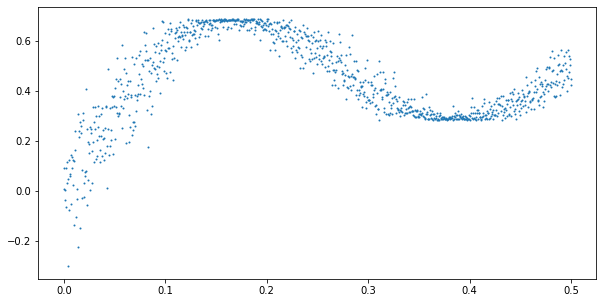

In [3]:
x = np.linspace(0, 0.5, 1000)
ε = 0.02 * np.random.randn(x.shape[0])
y = x + 0.3 * np.sin(2 * np.pi * (x + ε)) + 0.3 * np.sin(4 * np.pi * (x + ε)) + ε

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, 'o', markersize=1)

In [4]:
!pip3 install pyro-ppl

     |████████████████████████████████| 718 kB 8.4 MB/s 
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     |████████████████████████████████| 750.6 MB 49 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu111 requires torch==1.9.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.9.0 requires torch==1.9.0, but you have torch 1.11.0 which is incompatible.


In [5]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

In [23]:
class Model(PyroModule):
    def __init__(self, h1=20, h2=20):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](1, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, 1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h1]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc3(x).squeeze()
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return mu

In [24]:
model = Model()
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 1e-3})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
bar = trange(20)
x_train = torch.from_numpy(x).float()
y_train = torch.from_numpy(y).float()

for epoch in bar:
    loss = svi.step(x_train, y_train)
    bar.set_postfix(loss=f'{loss / x.shape[0]:.3f}')

100%|██████████| 20/20 [00:00<00:00, 212.11it/s, loss=1.157]


In [25]:
print(x_train.shape, y_train.shape)

torch.Size([1000]) torch.Size([1000])


torch.Size([3000])


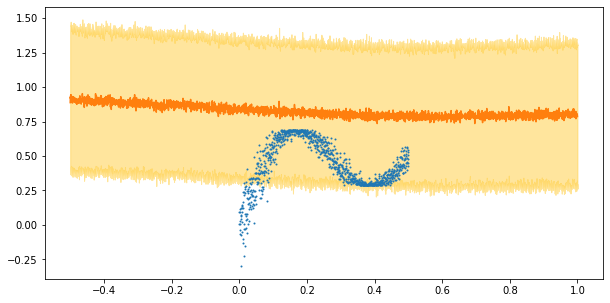

In [27]:
predictive = Predictive(model, guide=guide, num_samples=500)
x_test = torch.linspace(-0.5, 1, 3000)
preds = predictive(x_test)
print(x_test.shape)
y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, 'o', markersize=1)
ax.plot(x_test, y_pred)
ax.fill_between(x_test, y_pred - y_std, y_pred + y_std,
                alpha=0.5, color='#ffcd3c')